# ATTENTION: the newest notebook is in my laptop's provide folder as only there the XKCD font works ---

# TODO: Adapt notebook to show idealised OVERSHOOT scenario:

Before we continue, let's have a look at the expected contribution of glaciers to local streamflow.  The chart below shows an idealized scenario where the climate is first constant (t$_0$-t$_1$, and the glacier is in equilibrium with its climate) and then a warming occurs (t$_1$-t$_2$). This graph makes a few very important points, which we will explore together in this notebook. 

1. When a glacier is in equilibrium, a glacier does not contribute to the annual runoff at all. 
2. When the climate is warming, glaciers are losing mass. This water contributes to downstream runoff, and the runoff increases.
3. If climate warms even more, glaciers will continue to lose mass and become significantly smaller. When there isn't much ice left to melt each year (or when climate stabilizes), their contribution will become smaller until becoming zero again.
4. In the new equilibrium, the annual runoff is the same as before, but the seasonal contribution changed.

We will now get back to all these points together, using OGGM!

<img src="https://raw.githubusercontent.com/OGGM/oggm-edu/master/docs/_static/fig_huss_hock.jpg" width="700px" alt="Fig 1 from https://www.nature.com/articles/s41558-017-0049-x">

*Graphic from [Huss & Hock (2018)](https://www.nature.com/articles/s41558-017-0049-x)*

## Setup 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')  # plot defaults

In [2]:
import xarray as xr
import salem
import numpy as np
import pandas as pd

In [3]:
import oggm.cfg
from oggm import utils, workflow, tasks, graphics
from oggm.sandbox.edu import run_constant_climate_with_bias

In [4]:
# OGGM options
oggm.cfg.initialize(logging_level='WARNING')
oggm.cfg.PATHS['working_dir'] = utils.gettempdir(dirname='WaterResources')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is defined when ice is thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True

2023-04-20 07:46:12: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-20 07:46:12: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-20 07:46:12: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-04-20 07:46:12: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2023-04-20 07:46:12: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


### Define the glacier we will play with

For this notebook we use the Hintereisferner, Austria. Some other possibilities to play with:

- Hintereisferner, Austria: RGI60-11.00897 
- Artesonraju, Peru: RGI60-16.02444
- Rikha Samba, Nepal: RGI60-15.04847
- Parlung No. 94, China: RGI60-15.11693

And virtually any glacier you can find the RGI Id from, e.g. in the [GLIMS viewer](https://www.glims.org/maps/glims)! Large glaciers may need longer simulations to see changes though. For less uncertain calibration parameters, we also recommend to pick one of the many reference glaciers [in this list](https://github.com/OGGM/oggm-sample-data/blob/master/wgms/rgi_wgms_links_20200415.csv), where we make sure that observations of mass balance are better matched. 


Let's start with Hintereisferner first and you'll be invited to try out your favorite glacier at the end of this notebook.

In [5]:
# Hintereisferner
#rgi_id = 'RGI60-11.00897'
rgi_id = 'RGI60-11.01450' #, 'RGI60-15.11693' #'RGI60-11.01450'

## Preparing the glacier data

This can take up to a few minutes on the first call because of the download of the required data:

In [6]:
# We pick the elevation-bands glaciers because they run a bit faster - but they create more step changes in the area outputs
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5'
gdir = workflow.init_glacier_directories([rgi_id], from_prepro_level=5, prepro_border=80, prepro_base_url=base_url)[0]

2023-04-20 07:46:15: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2023-04-20 07:46:15: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


## Interactive glacier map 

A first glimpse on the glacier of interest.

*Tip: You can use the mouse to pan and zoom in the map*

In [7]:
# One interactive plot below requires Bokeh
try:
    import holoviews as hv
    hv.extension('bokeh')
    import geoviews as gv
    import geoviews.tile_sources as gts

    sh = salem.transform_geopandas(gdir.read_shapefile('outlines'))
    out = (gv.Polygons(sh).opts(fill_color=None, color_index=None) * 
           gts.tile_sources['EsriImagery'] * 
           gts.tile_sources['StamenLabels']).opts(width=800, height=500, active_tools=['pan', 'wheel_zoom'])
except:
    # The rest of the notebook works without this dependency
    out = None
out

For OGGM, glaciers are "1.5" dimensional along their flowline:

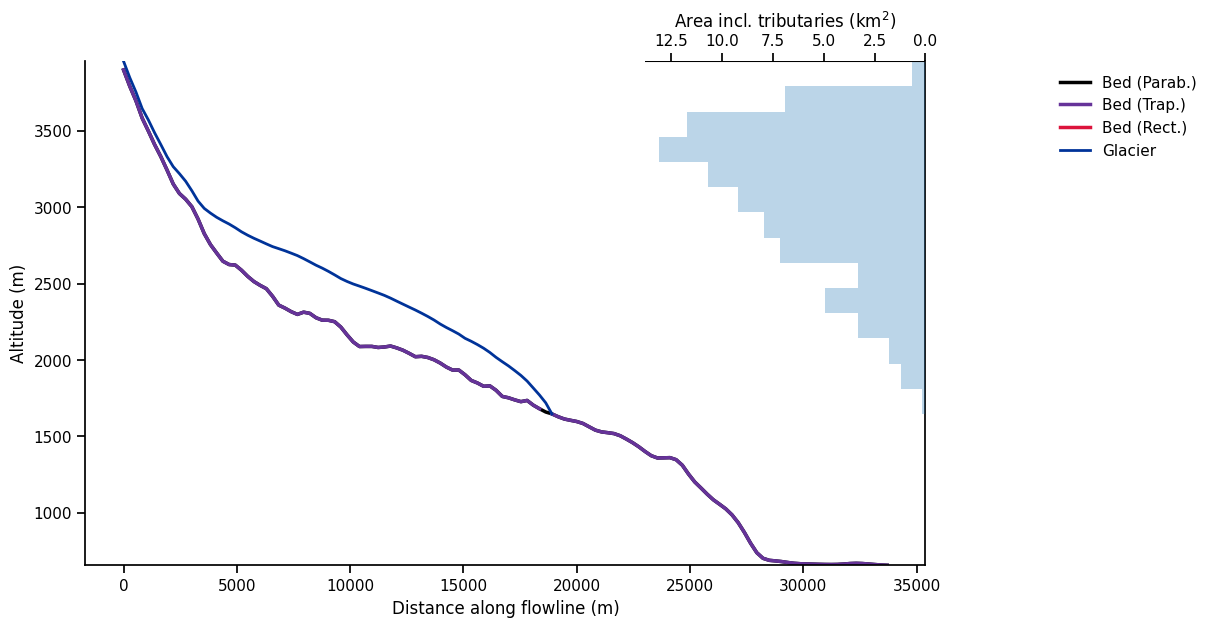

In [8]:
fls = gdir.read_pickle('model_flowlines')
graphics.plot_modeloutput_section(fls);

## Generating a glacier in equilibrium with climate 

Let's prepare a run with the `run_constant_climate_with_bias` tasks from the `oggm_edu` package. It allows us to run idealized temperature and precipitation correction scenarios in an easy way. 

First, let's decide on a temperature evolution:

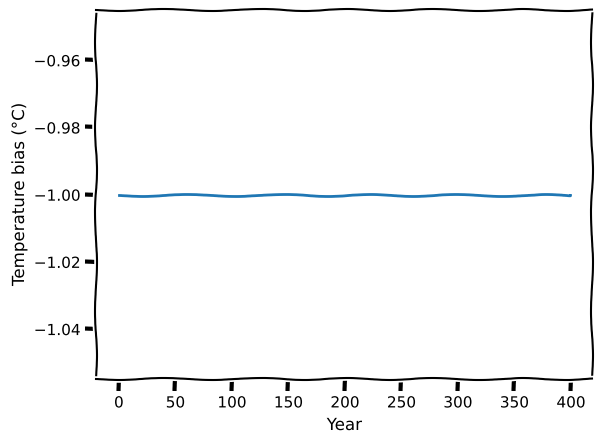

In [10]:
delta_t = -1
years = np.arange(400)
temp_bias_ts = pd.Series(years * 0. + delta_t, index=years)
with plt.xkcd():
    temp_bias_ts.plot(); 
    plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)');

Not much to see here! The `temp_bias_ts` variable describes a temperature bias that will be applied to the standard climate (see below). 

Here the bias is -2° all along because we want to run a so-called "spinup" run, to let the glacier grow and make sure that our glacier is in dynamical equilibrium with its climate at the end of the simulation. Let's go: 

In [11]:
# file identifier where the model output is saved
file_id = '_spinup'

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,  # Run on the selected glacier
                     temp_bias_ts=temp_bias_ts,  # the temperature bias to apply to the average climate
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     output_filesuffix=file_id);  # an identifier for the output file, to read it later

OK so there is quite some new material in the cell above. Let's focus on the most important points:
- we run the model for 400 years (as defined by our control temperature timeseries)
- the model runs with a constant climate averaged over 21 years (2 times `halfsize` + 1) for the period 1999-2019
- we apply a cold bias of -2°C. Indeed, Hintereisferner is in strong disequilibrium with the current climate and such a bias is needed to make the glacier grow (more on this later)

Now Let's have a look at the output now:

In [12]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

There are plenty of variables in this dataset! We can list them with:

In [13]:
ds

<xarray.Dataset>
Dimensions:                       (time: 399, month_2d: 12)
Coordinates:
  * time                          (time) float64 0.0 1.0 2.0 ... 397.0 398.0
    calendar_year                 (time) int64 0 1 2 3 4 ... 394 395 396 397 398
    calendar_month                (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    hydro_year                    (time) int64 0 1 2 3 4 ... 394 395 396 397 398
    hydro_month                   (time) int64 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    hydro_month_2d                (month_2d) int64 4 5 6 7 8 9 10 11 12 1 2 3
    calendar_month_2d             (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/21)
    volume_m3                     (time) float64 1.207e+10 ... 1.088e+10
    volume_bsl_m3                 (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    volume_bwl_m3                 (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    area_m2                       (time) float64 8.221e+07 ... 7.99e+07
    length_m                      (time) float64 1.891e+04 ... 1.699e+04
    calving_m3                    (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                            ...
    liq_prcp_on_glacier           (time) float64 5.65e+10 ... 5.347e+10
    liq_prcp_on_glacier_monthly   (time, month_2d) float64 0.0 0.0 ... 2.047e+04
    snowfall_off_glacier          (time) float64 6.799e+08 ... 4.669e+09
    snowfall_off_glacier_monthly  (time, month_2d) float64 1.397e+08 ... 8.67...
    snowfall_on_glacier           (time) float64 2.418e+11 ... 2.364e+11
    snowfall_on_glacier_monthly   (time, month_2d) float64 2.816e+10 ... 2.55...
Attributes:
    description:          OGGM model output
    oggm_version:         1.3.2.dev394+gb45b78b
    calendar:             365-day no leap
    creation_date:        2023-04-20 05:47:15
    water_level:          0
    glen_a:               6.079411329372713e-24
    fs:                   0
    mb_model_class:       BiasedConstantMassBalance
    mb_model_hemisphere:  nh
    mb_model_rho:         900.0
    mb_model_ys:          0
    mb_model_ye:          399

*Tip: you can click on a variable and show it's attribute with the "page" button on the right.*

The `time` and `month_2d` variables are coordinates, and the other variables are either provided as additional information (e.g. `hydro_month`, we will get back to this), or they are providing the actual data. For instance, we can plot the annual evolution of the volume and length of our glacier:

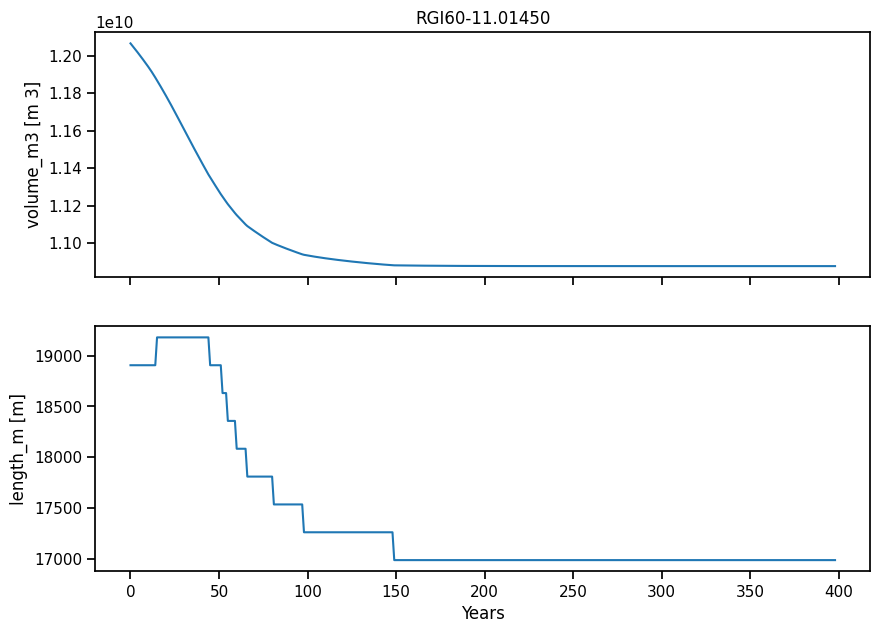

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0]);
ds.length_m.plot(ax=axs[1]);
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel('Years');

The glacier grows and almost doubles its volume. After 400 years, it is in equilibrium.

This spinup simulation won't be analyzed further: let's jump to the heart of the topic: **what happens with glacier runoff when climate is warming**?

## Climate change simulation

We start by generating a temperature change scenario. We define a short period of constant temperature (at -2°C, to be consistent with above), followed by a linear increase (2.5 degrees in about 150 years) and a stabilization:

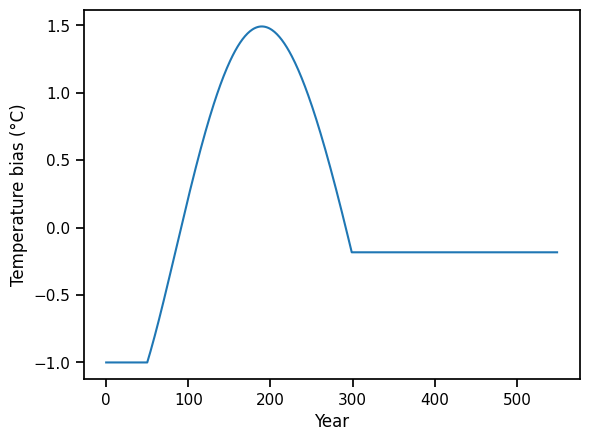

In [15]:
ny_s=50
ny_e=250
f = np.array([-4.36202118e-12,  5.34151857e-09, -2.03858079e-06,
              1.76227795e-04, 2.0097832e-02, -6.39048239e-01])
x = np.arange(0,250,1)
y= f[5] + f[4]*x + f[3]*x**2+f[2]*x**3+f[1]*x**4 + f[0]*x**5

ys = np.concatenate([np.full(ny_s, y[0]), y, np.full(ny_e, y[-1])])
temp_bias_ts = pd.Series(ys-(y[0]-delta_t), index=np.arange(0,250+ny_s+ny_e,1))
temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)');

In [16]:
# file identifier where the model output is saved
file_id = '_oversh_temp'

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix=file_id);  # an identifier for the output file, to read it later

Let's have a look at our glacier evolution:

In [17]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

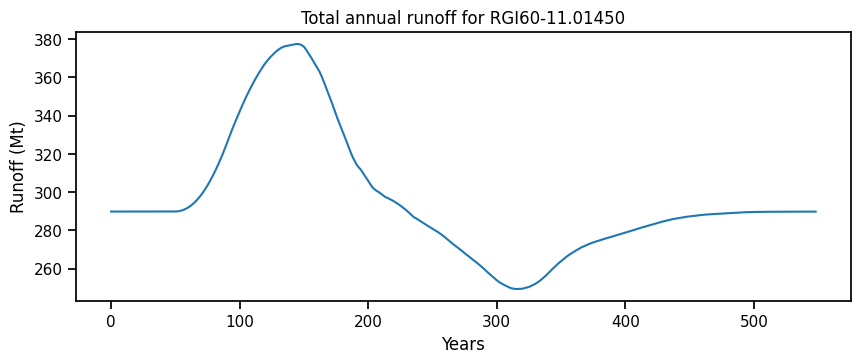

In [18]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

# Select only the runoff variables
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
# Convert them to megatonnes (instead of kg)
df_runoff = df_annual[runoff_vars] * 1e-9
# We smooth the output, which is otherwize noisy because of area discretization
df_runoff = df_runoff.rolling(41, center=False, min_periods=1).mean()

labels_nice_dict = {'melt_off_glacier': 'melt off glacier',
 'melt_on_glacier': 'melt on glacier',
 'liq_prcp_off_glacier': 'liquid precipitation off glacier',
 'liq_prcp_on_glacier': 'liquid precipitation on glacier'}

df_runoff = df_runoff.rename(columns=labels_nice_dict)
fig, ax = plt.subplots(figsize=(10, 3.5), sharex=True)
df_runoff.sum(axis=1).plot(ax=ax);
plt.ylabel('Runoff (Mt)'); plt.xlabel('Years'); plt.title(f'Total annual runoff for {rgi_id}');

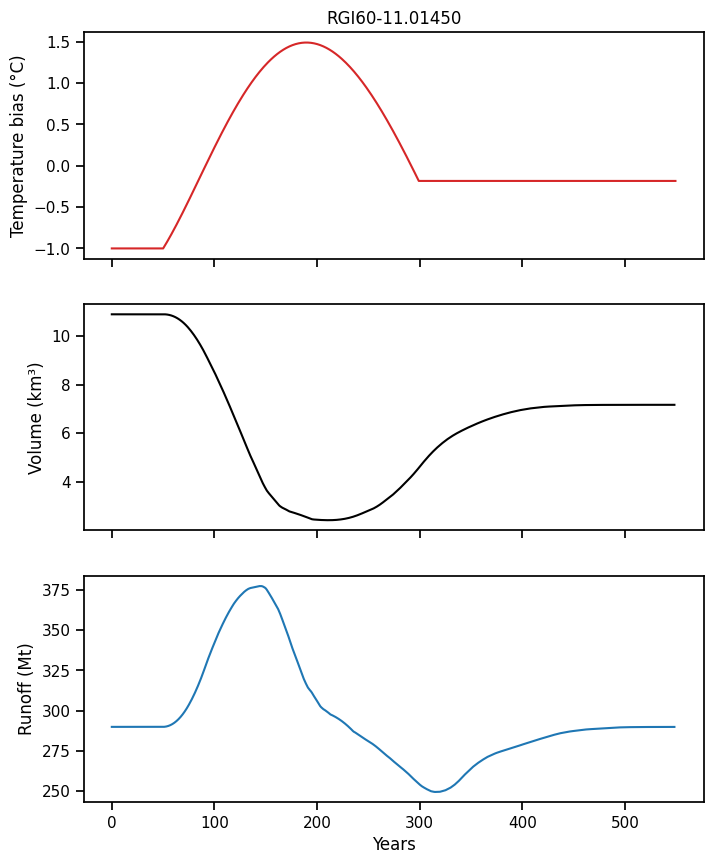

In [19]:
plt.rc('font', size=26)
fig, axs = plt.subplots(nrows=3, figsize=(8, 10), sharex=True)
(ds.volume_m3/1e9).plot(ax=axs[1], c='black');
axs[1].set_ylabel('Volume (km³)')
#ds.length_m.plot(ax=axs[1]);
temp_bias_ts.plot(ax=axs[0], c='C3');


df_runoff.sum(axis=1).plot(ax=axs[2], label = 'Total annual runoff');
plt.ylabel('Runoff (Mt)'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
axs[2].set_xlabel('Years'); axs[0].set_ylabel('Temperature bias (°C)');

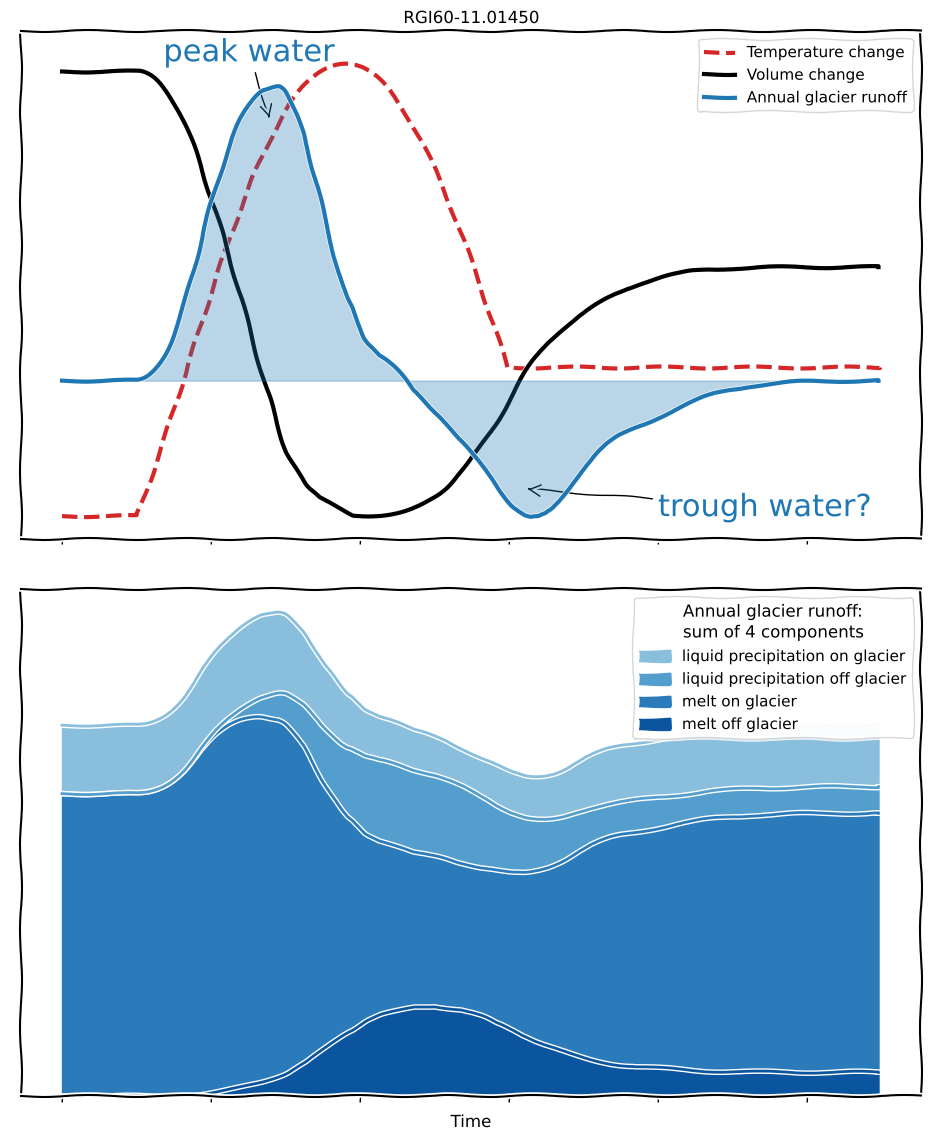

In [26]:
with plt.xkcd():
    plt.rc('font', size=26)
    fig, axs = plt.subplots(nrows=2, figsize=(10, 12), sharex=True)

    ax = axs[0]
    temp_bias_ts.plot(ax=ax, c='C3', label = 'Temperature change',ls='--', lw=3);
    ax2 = ax.twinx()

    (ds.volume_m3/1e9).plot(ax=ax2, c='black', label ='Volume change', lw=3);
    ax.set_ylabel('')
    #ds.length_m.plot(ax=axs[1]);

    ax.set_title('')
    ax3 = ax2.twinx()
    df_runoff.sum(axis=1).plot(ax=ax3, label = 'Annual glacier runoff', c='C0', lw=3);
    plt.ylabel(''); #plt.xlabel('Time'); #plt.title(f'Total annual runoff for {rgi_id}');
    ax.set_xlabel('Time'); 
    ax.set_title(f'{rgi_id}'); axs[0].set_xlabel('');
    ax.set_ylabel('');
    ax2.set_ylabel('')
    ax.set_xticks([],[])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])

    handles = []
    labels = []
    for axi in [ax,ax2,ax3]:
        handi, labeli = axi.get_legend_handles_labels()
        handles.append(handi[0])
        labels.append(labeli[0])

    plt.legend(handles, labels)
    #ax.legend(loc='upper left', bbox_to_anchor=(0.65,1))
    #ax2.legend(loc='upper left', bbox_to_anchor=(0.65,0.95))
    #ax3.legend(loc='upper left', bbox_to_anchor=(0.65,0.9))
    #ax3.axhline(df_runoff.iloc[0].sum(), c='C0', ls=':', lw=3)
    ax3.fill_between(df_runoff.index,
                     df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).values, alpha = 0.3, color='C0')
    ax3.set_ylim([ax3.get_ylim()[0], ax3.get_ylim()[1]*1.025])
    ax2.set_ylim([ax2.get_ylim()[0], ax2.get_ylim()[1]*1.03])
    ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]*1.03])

    ax.annotate('peak water',(140,1.17), xytext=(68,1.5), color='C0',
               arrowprops={'arrowstyle':'->'}, fontsize=22)

    ax.annotate('trough water?',(310,-0.85), xytext=(400,-1), color='C0',
               arrowprops={'arrowstyle':'->'}, fontsize=22)

    ax = axs[1]
    df_runoff.plot.area(ax=ax, color=sns.color_palette('Blues_r')); 
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Annual glacier runoff:\nsum of 4 components', loc='upper right')
    #plt.xlabel('Years'); 
    #plt.ylabel('Runoff (Mt)');
    ax.set_ylabel('');
    ax.set_xlabel('Time');
    #ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_xticks([],[])

    plt.tight_layout();

    ax.set_xlabel('Time');
    plt.tight_layout()
    #ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
    plt.savefig('conceptual_model.pdf')

In this scenario, the glacier would melt almost entirely (it looses about 90% of its volume). Note also that the glacier continues to adjust after the temperature has stabilized. **What are the implications for downstream runoff?**

### Annual runoff

As glaciers retreat, they contribute to sea level rise (visit the [World Glaciers Explorer](https://edu.oggm.org/en/latest/explorer.html) OGGM-Edu app for more information!). This is not what we are interested in here. Indeed, they will also have important local impacts: in this notebook, we will have a look at their impact on streamflow.  

Let's take a look at some of the hydrological outputs computed by OGGM. We start by creating a pandas DataFrame of all "1D" (annual) variables in the output dataset:

Then we can select the hydrological variables and sum them to get the total annual runoff:

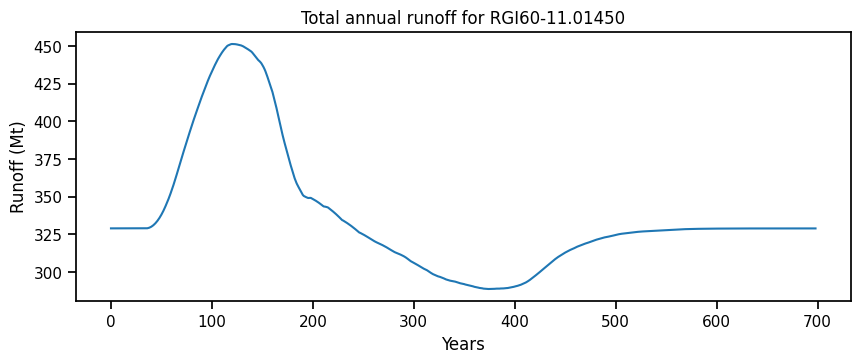

The hydrological variables are computed on the largest possible area that was covered by glacier ice during the simulation. This is equivalent to the runoff that would be measured at a fixed-gauge hydrological station at the glacier terminus.

The total annual runoff consists of the following components:
- melt off-glacier: snow melt on areas that are now glacier free (i.e. 0 in the year of largest glacier extent, in this example at the start of the simulation)
- melt on-glacier: ice + seasonal snow melt on the glacier
- liquid precipitaton on- and off-glacier (the latter being zero at the year of largest glacial extent, in this example at start of the simulation)

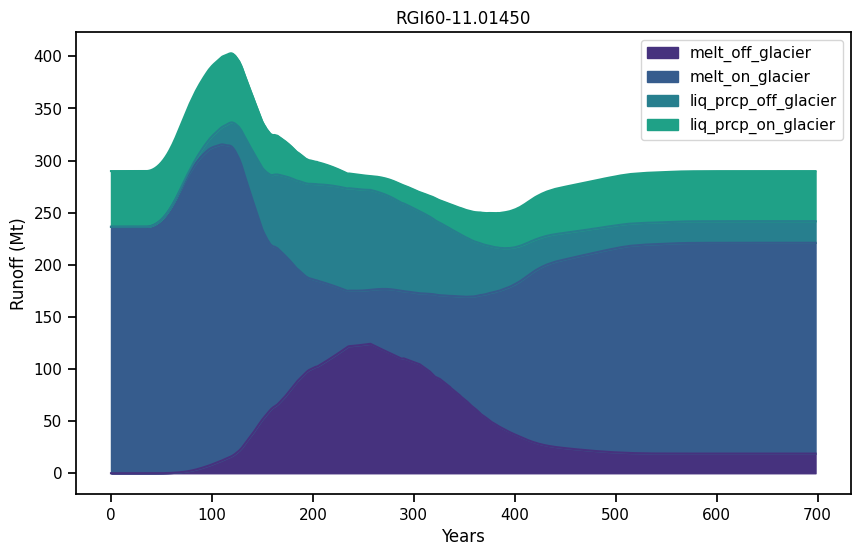

In [187]:
f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette('viridis')); plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(rgi_id);

The glacier length and volume decrease from year 50 onwards until about year 250 - this is the **glacier retreat** phase. Afterwards, length and volume stabilize at a constant value indicating that the glacier has **reached equilibrium**. 

Now study the graph above and it's four main components.

**Questions to address:**
- When is "peak water" reached? Does this have anything to do with a change in the temperature trend itself? If not, what is the reason for "peak water" to occur?
- Verify that the total fixed-gauge runoff (remember what this means?) is the same at the beginning and the end of the simulation. Why is that so? What changed in between?
- The temperature stabilizes at year 200, yet all hydrological variables continue to change after that. What is happening there?
- What is the contribution of liquid precipitation at the beginning and the end of the simulation? What changed?
- Can you verify that the net glacier contribution to runoff (i.e. - $\Delta M / \Delta t$) is zero at the beginning and the end of the simulation and positive in between? Why do we expect this behavior?

*Hint: compare the results to the idealised runoff graphic that we introduced at the beginning of this chapter*

In [ ]:
# Solution of the last question above
glacier_mass = ds.volume_m3.to_series() * oggm.cfg.PARAMS['ice_density'] * 1e-9  # In Megatonnes, Mt
glacier_mass = glacier_mass.rolling(31, center=True, min_periods=1).mean()
(- glacier_mass.diff()).plot()
plt.axhline(y=0, color='k', ls=':')
plt.ylabel('Annual glacier mass change (Mt yr$^{-1}$)')
plt.xlabel('Years'); plt.title('Glacier contribution to annual runoff');

### Monthly runoff

The "2D" variables contain the same hydrological data, but at monthly resolution (dimensions [time, month]). For example, monthly runoff can be computed as:

In [ ]:
# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly'] + ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly']
monthly_runoff = monthly_runoff.rolling(time=31, center=True, min_periods=1).mean() * 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label': 'Runoff (Mt)'}); plt.xlabel('Months'); plt.ylabel('Years');

As we can see, the runoff is approximately zero during the winter months, while relatively high during the summer months. 

Now let's compare the actual runoff to total precipitation over the basin:

In [ ]:
# Compute total precipitation (Snow + Liquid)
tot_precip = ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly'] + ds['snowfall_off_glacier_monthly'] + ds['snowfall_on_glacier_monthly']
tot_precip *= 1e-9  # in Mt

In [ ]:
# Plot these data at year 0
yr = 0
r = monthly_runoff.sel(time=yr)
p = tot_precip.sel(time=yr)

f, ax = plt.subplots(figsize=(10, 6));
r.plot(ax=ax, color='C3', label='Monthly runoff', linewidth=3);
p.plot(ax=ax, color='C0', label='Monthly precipitation', linewidth=3);
ax.fill_between(r.month_2d, r, p, where=(p >= r), facecolor='C0', interpolate=True, alpha=0.5)
ax.fill_between(r.month_2d, r, p, where=(r > p), facecolor='C3', interpolate=True, alpha=0.5)
plt.ylabel('Mt yr$^{-1}$'); plt.legend(loc='best');
plt.xlabel('Month'); plt.title(f'Total monthly runoff and precipitation at year {yr}');

At the begining of the simulation, the glacier is in equilibrium and its annual contribution to runoff is zero. In fact, this means that the blue area in the plot above is equal to the red area: **the glaciated basin releases water during the summer, that accumulated in form of snow in the winter months**.

In this region (Ötztal Alps, Austria), precipitation is relatively constant throughout the year. **Discuss what the implications could be in other climates of the world, in particular in climates with a strong seasonality of precipitation.**

Now let's have a look at the seasonal change in runoff with time:

In [ ]:
f, ax = plt.subplots(figsize=(10, 6));
cmap = sns.color_palette('magma', 3)
for i, yr in enumerate([0, 120, 300]):
    monthly_runoff.sel(time=yr).plot(ax=ax, color=cmap[i], label=f'Year {yr}')
plt.ylabel('Mt yr$^{-1}$'); plt.legend(loc='best');
plt.xlabel('Month'); plt.title('Total monthly runoff change with time');

**Questions to explore:**
- verify that the annual runoff is the same at year 0 than at year 300. What changed in between?
- what is responsible for the switch from summer melt to spring melt?
- how does the runoff change at "peak water" (approx. year 120)?
- discuss the implications of this shift in seasonality for Hintereisferner and for other regions of the world.

**Now repeat this notebook (ideally by copying it first) with other regions of the world, where climate might be very different.**

Note that our explanations are very glacier-specific. So if you change the glacier by using another rgi_id, you also might need to adapt the explanations! 

**You can also change the parameters of the simulations!**

What happens when the temperature change is larger/faster, smaller/slower? What are the implications for "peak water"?

## Wrapping up

Now let's conclude this notebook by reproducing the famous plot by [Huss & Hock (2018)](https://www.nature.com/articles/s41558-017-0049-x) with our data.

<img src="https://raw.githubusercontent.com/OGGM/oggm-edu/master/docs/_static/fig_huss_hock.jpg" width="700px" alt="Fig 1 from https://www.nature.com/articles/s41558-017-0049-x">

*Graphic from [Huss & Hock (2018)](https://www.nature.com/articles/s41558-017-0049-x)*

In [ ]:
# Make a dataframe out of the xarray dataset for simplicity
df_monthly_runoff = pd.DataFrame(monthly_runoff.data, index=ds.time, columns=monthly_runoff.month_2d)

# Create new columns for each season (we define seasons from the perspective of the northern Hemisphere)
df_monthly_runoff['Spring (Apr-Jun)'] = df_monthly_runoff[[4, 5, 6]].sum(axis=1)
df_monthly_runoff['Summer (Jul-Sep)'] = df_monthly_runoff[[7, 8, 9]].sum(axis=1)
df_monthly_runoff['Winter (Oct-Mar)'] = df_monthly_runoff[[10, 11, 12, 1, 2, 3]].sum(axis=1)
df_monthly_runoff.columns.name = 'Season'

# Plot it
# Attention the seasons and labels might need to be adapted if a glacier in a different region is used!
f, ax = plt.subplots(figsize=(10, 6));
df_monthly_runoff[['Spring (Apr-Jun)', 'Summer (Jul-Sep)', 'Winter (Oct-Mar)']].plot.area(ax=ax, color=sns.color_palette('rocket'));
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title('Runoff by season');

And now the actual plot:

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10, 8), sharex=True)

p1 = df_monthly_runoff[['Spring (Apr-Jun)', 'Summer (Jul-Sep)', 'Winter (Oct-Mar)']].sum(axis=1)
p2 = df_monthly_runoff['Summer (Jul-Sep)'] # July to September is here the melt season
p1.plot(ax=ax1, color='C0', label='Annual runoff', linewidth=3)
p2.plot(ax=ax1, color='C3', label='Melt-season runoff', linewidth=3);
ax1.hlines([p1.loc[0], p2.loc[0]], 0, 300, color=['C0', 'C3'], linestyle=[':']);
ax1.legend(); ax1.set_xlabel(''); ax1.set_ylabel('Runoff (Mt)');

(temp_bias_ts + 2).plot(ax=ax2, color='C2', label='Temperature', linewidth=3);
ax2.legend(loc='lower right'); ax2.set_xlabel('Years'); ax2.set_ylabel('$\Delta T (°C)$');
sns.despine();

Note that the two plots above are very glacier-specific. If you use a glacier with another climate, you might need to adapt the plots, because we are always interested in those months where the runoff from the glacier contributes most to the total runoff. Example given, for Artesonraju in Peru, we are most interested in June, July, August and September as this is the dry season, where it almost does not rain at all. 

## Take home points

- Glaciers in equilibrium are *not* net water resources: they gain as much mass as they release
- However, they have a seasonal buffer role, releasing water during the melt months
- When glaciers melt, they become net water resources. "Peak water" is the point in time when glacier melt supply reaches its maximum, i.e. when the maximum runoff occurs.

## References 

- Huss, M. and Hock, R.: Global-scale hydrological response to future glacier mass loss, Nat. Clim. Chang., 8(2), 135–140, [doi:10.1038/s41558-017-0049-x](https://doi.org/10.1038/s41558-017-0049-x), 2018.
- A [recent blog post](https://blogs.egu.eu/divisions/cr/2021/03/05/glaciers-water-supply-climate-change/) about the role of glaciers in the hydrological cycle

## What's next?

[Back to the table of contents](../welcome.ipynb)